# Multiple Linear Regression

This notebook explains linear regression models for the purpose of prediction. It discusses the differences between fitting and using regression models for the purpose of inference (as in classical statistics) and for prediction. A predictive goal calls for evaluating model performance on a validation set, and for using predictive metrics. It then raises the challenges of using many predictors and describes variable selection algorithms that are often implemented in linear regression procedures.

## Imports

Imports required for this notebook

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from dmutils.utils import regression_summary

import pandas as pd
import matplotlib.pyplot as plt

## Introduction

The most popular model for making predictions is the *multiple linear regression model* encountered in most introductory statistics courses and textbooks. This model is used to fit a relationship between a numerical *outcome variable Y* (also called the *response*, *target*, or *dependent variable*) and a set of *predictors* $X_1$, $X_2$, ..., $X_p$ (also referred to as *independent variables*, *input variables*, *regressors*, or *covariates*). The assumption is that the following function approximates the relationship between the predictors and outcome variable:


<p>
    <center>
        $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p + \epsilon$
    </center>
</p>

where $\beta_0$, ..., $\beta_p$ are *coefficients* and $\epsilon$ is the *noise* or *unexplained* part. Data are then used to estimate the coefficients and to quantify the noise. In predictive modeling, the data are also used to evaluate model performance.

Regression modeling means not only estimating the coefficients but also choosing which predictors to include and in what form. For example, a numerical predictor can be included as is, or in logarithmic form $[\log (X)]$, or in a binned form (e.g., age group). Choosing the right form depends on domain knowledge, data availability, and needed predictive power.

Multiple linear regression is applicable to numerous predictive modeling situations. Examples are predicting customer activity on credit cards from their demographics and historical activity patterns, predicting expenditures on vacation travel based on historical frequent flyer data, predicting staffing requirements at help desks based on historical data and product and sales information, predicting sales from cross-selling of products from historical information, and predicting the impact of discounts on sales in retail outlets.

## Exploratory vs. Predictive modeling

Before introducing the use of linear regression for prediction, one must clarify an important distinction that often escapes those with earlier familiarity with linear regression from courses in statistics. In particular, the two popular but different objectives behind fitting a regression model are:

1. Explaining or quantifying the average effect of inputs on an outcome (explanatory or descriptive task, respectively)

2. Predicting the outcome value for new records, given their input values (predictive task)

The classical statistical approach is focused on the first objective. In that scenario, the data are treated as a random sample from a larger population of interest. The regression model estimated from this sample is an attempt to capture the *average* relationship in the larger population. This model is then used in decision-making to generate statements such as "a unit increase in service speed ($X_1$) is associated with an average increase of 5 points in customer satisfaction ($Y$), all other factors ($X_2$, $X_3$, ..., $X_p$) being equal.". If $X_1$ is known to cause $Y$, then such a statement indicates actionable policy changes - this is called explanatory modeling. When the causal structure is unknown, then this model quantifies the degree of* association* between the inputs and outcome variable, and the approach is called descriptive modeling.

In predictive analytics, however, the focus is typically on the second goal: predicting new individual records. Here we are not interested in the coefficients themselves, nor in the "average record", but rather in the predictions that this model can generate for new records. In this scenario, the model is used for micro-decision-making at the record level. As a practical example, it could be used to predict customer satisfaction for each new customer of interest.

Both explanatory and predictive modeling involve using a dataset to fit a model (i.e., to estimate coefficients), checking model validity, assessing its performance, and comparing to other models. However, the modeling steps and performance assessment differ in the two cases, usually leading to different final models. Therefore, the choice of model is closely tied to whether the goal is explanatory or predictive.

In explanatory and descriptive modeling, where the focus is on modeling the average record, the attempt is to fit the best model to the data to learn about the underlying relationship in the population. In contrast, in predictive modeling (data mining), the goal is to find a regression model that best predicts new individual records. A regression model that fits the existing data too well is not likely to perform well with new data. Hence, we look for a model that has the highest predictive power by evaluating it on a holdout set and using predictive metrics.

Let us summarize the main differences in using a linear regression in the two scenarios:

1. A good explanatory model is one that fits the data closely, whereas a good predictive model is one that predicts new records accurately. Choices of input variables and their form can therefore differ.

2. In explanatory models, the entire dataset is used for estimating the best-fit model, to maximize the amount of information that we have about the hypothesized relationship in the population. When the goal is to predict outcomes of new individual records, the data are typically split into a training set and a validation set. The training set is used to estimate the model, and the validation or *holdout set* is used to assess this model's predictive performance on new, unobserved data.

3. Performance measures for explanatory models measure how close the data fit the model (how well the model approximates the data) and how strong the average relationship is, whereas in predictive models performance is measured by predictive accuracy (how well the model predicts new individual records).

4. In explanatory models the focus is on the coefficients ($\beta$), whereas in predictive models the focus is on the predictions ($\hat{y}$).

For these reasons, it is extremely important to know the goal of the analysis before beginning the modeling process. A good predictive model can have a looser fit to the data on which it is based, and a good explanatory model can have low prediction accuracy. Therefore, the remainder of this notebook focuses on predictive models because these are more popular in data mining and because most statistics textbooks focus on explanatory modeling.

## Estimating the Regression Equation and Prediction

Once determined the predictors to include and their form, we estimate the coefficients of the regression formula from the data using a method called *ordinary least squares* (OLS). This method finds values $\hat{\beta}_0$, $\hat{\beta}_1$, $\hat{\beta}_2$, ..., $\hat{\beta}_p$ that minimize the sum of squared deviations between the actual outcome values ($Y$) and their predicted values based on that model ($\hat{Y}$).

To predict the value of the outcome variable for a record with predictor values $x_1$, $x_2$, ..., $x_p$, we use the equation:

<p>
    <center>
        $\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + ... + \hat{\beta}_p x_p$
    </center>
</p>

Predictions based on this equation are the best predictions possible in the sense that they will be unbiased (equal to the true values on average) and will have the smallest mean squared error compared to any unbiased estimates *if* we make the following assumptions:

1. The noise $\epsilon$ (or equivalently, $Y$) follows a normal distribution.

2. The choice of predictors and their form is correct (*linearity*).

3. The records are independent of each other.

4. The variability in the outcome values for a given set of predictors is the same regardless of the values of the predictors (*homoskedasticity*).

An important and interesting fact for the predictive goal is that *even if we drop the first assumption and allow the noise to follow an arbitrary distribution, these estimates are very good for prediction*, in the sense that among all linear models, as defined by equation above, the model using the least squares estimates, $\hat{\beta}_0$, $\hat{\beta}_1$, $\hat{\beta}_2$, ..., $\hat{\beta}_p$, will have the smallest mean squared errors. The assumption of a normal distribution is required in explanatory modeling, where it is used for constructing confidence intervals and statistical tests for the model parameters.

Even if the other assumptions are violated, it is still possible that the resulting predictions are sufficiently accurate and precise for the purpose they are intended for. The key is to evaluate predictive performance of the model, which is the main priority. Satisfying assumptions is of secondary interest and residual analysis can give clues to potential improved models to examine.

### Example: Predicting the Price of Used Toyota Corolla Cars

A large Toyota car dealership offers purchasers of new Toyota cars the option to buy their used car as part of a trade-in. In particular, a new promotion promises to pay high prices for used Toyota Corolla cars for purchasers of a new car. The dealer then sells the used cars for a small profit. To ensure a reasonable profit, the dealer needs to be able to predict the price that the dealership will get for the used cars. For that reason, data were collected on all previous sales of used Toyota Corollas at the dealership. The data include the sales price and other information on the car, such as its age, mileage, fuel type, and engine size. A description of each of these variables is given below:


    Price: Offer price in Euros
    Age: Age in months as of August 2004
    Kilometers: Accumulated kilometers on odometer
    Fuel type: Fuel type (Petrol, Diesel, CNG)
    HP: Horsepower
    Metallic: Metallic color? (Yes = 1, No = 0)
    Automatic: Automatic (Yes = 1, No = 0)
    CC: Cylinder volume in cubic centimeters
    Doors: Number of doors
    QuartTax: Quarterly road tax in Euros
    Weight: Weight in kilograms

A sample of this dataset is shown below. The total number of records in the dataset is 1000 cars (we use the first 1000 cars from the dataset `ToyotoCorolla.csv`).After partitioning the data into training (60%) and validation
(40%) sets, we fit a multiple linear regression model between price (the outcome variable) and the other variables (as predictors) using only the training set.

In [2]:
# reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = pd.read_csv("../datasets/ToyotaCorolla.csv")
car_df = car_df.iloc[0:1000]

car_df.head(5)

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,0,1,0,1,0,0,0,0


Below are the coefficients of the Multiple Linear Regression model:

In [3]:
predictors = ["Age_08_04", "KM", "Fuel_Type", "HP", "Met_Color", "Automatic", "CC",
              "Doors", "Quarterly_Tax", "Weight"]
outcome = "Price"

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.4,
                                                      random_state=1)
car_lmr = LinearRegression()
car_lmr.fit(train_X, train_y)

# print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lmr.coef_}))
# print performance measures (training data)
regression_summary(train_y, car_lmr.predict(train_X))

           Predictor  coefficient
0          Age_08_04  -140.748761
1                 KM    -0.017840
2                 HP    36.103419
3          Met_Color    84.281830
4          Automatic   416.781954
5                 CC     0.017737
6              Doors   -50.657863
7      Quarterly_Tax    13.625325
8             Weight    13.038711
9   Fuel_Type_Diesel  1066.464681
10  Fuel_Type_Petrol  2310.249543

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1400.5823
            Mean Absolute Error (MAE) : 1046.9072
          Mean Percentage Error (MPE) : -1.0223
Mean Absolute Percentage Error (MAPE) : 9.2994


Notice that the Fuel Type predictor has three categories (Petrol, Diesel, and CNG). We therefore have two dummy variables in the model: Fuel_Type_Petrol (0/1) and Fuel_Type_Diesel (0/1); the third, for CNG (0/1), is redundant given the information on the first two dummies. Including the redundant dummy would cause the regression to fail, since the redundant dummy will be a perfect linear combination of the other two.

The regression coefficients are then used to predict prices of individual used Toyota Corolla cars based on their age, mileage, and so on. Below is a sample of predicted prices for 20 cars in the validation set, using the estimated model. It gives the predictions and their errors (relative to the actual prices) for these 20 cars. Below the predictions, we have overall measures of predictive accuracy. Note that the mean
error (ME) is \\$104 and RMSE = \\$1,313.

In [4]:
# Use predict() to make predictions on a new set
car_lmr_pred = car_lmr.predict(valid_X)
result = pd.DataFrame({"Predicted": car_lmr_pred,
                       "Actual": valid_y,
                       "Residual": valid_y - car_lmr_pred})
print(result.head(20))
# print performance measures (validation data)
regression_summary(valid_y, car_lmr_pred)

        Predicted  Actual     Residual
507  10607.333940   11500   892.666060
818   9272.705792    8950  -322.705792
452  10617.947808   11450   832.052192
368  13600.396275   11450 -2150.396275
242  12396.694660   11950  -446.694660
929   9496.498212    9995   498.501788
262  12480.063217   13500  1019.936783
810   8834.146068    7950  -884.146068
318  12183.361282    9900 -2283.361282
49   19206.965683   21950  2743.034317
446  10987.498309   11950   962.501691
142  18501.527375   19950  1448.472625
968   9914.690947    9950    35.309053
345  13827.299932   14950  1122.700068
971   7966.732543   10495  2528.267457
133  17185.242041   15950 -1235.242041
104  19952.658062   19450  -502.658062
6    16570.609280   16900   329.390720
600  13739.409113   11250 -2489.409113
496  11267.513740   11750   482.486260

Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
        

A histogram of the residuals shows that most of the errors are between ± \\$2000. This error magnitude might be small relative to the car price, but should be taken into account when considering the profit. Another observation of interest is the large positive residuals (under-predictions), which may or may not be a concern, depending on the application. Measures such as the mean error, and error percentiles are used to assess the predictive performance of a model and to compare models.

Percentage of datapoints with a residual in [-1406, 1406]:  0.7425


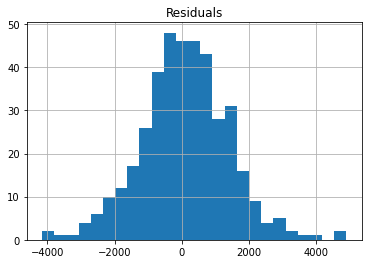

In [5]:
all_residuals = valid_y - car_lmr_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75%
print("Percentage of datapoints with a residual in [-1406, 1406]: ",
      len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

pd.DataFrame({"Residuals": all_residuals}).hist(bins=25)
plt.show()